```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - PM2.5 - Moving Average (MA)

## Contents

- [Moving Average (MA) modelling](#base)
- Hourly forecast
    - [Load hourly data](#data_h)
    - [Modelling (train, predict/validate)](#model_h)
- Daily forecast
    - [Load daily data](#data_d)
    - [Modelling](#model_d)

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import sys
sys.path.insert(0, '../src')

In [56]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [8]:
import pandas as pd 
import numpy as np

#from pandas.plotting import lag_plot
#from pandas.plotting import autocorrelation_plot

#from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
from model import (
    get_pm25_data_for_modelling,
    get_best_arima_params_for_time_series,
    #get_df_for_lags_columns,
    split_df_for_ts_modelling_offset,
    #predict_ar
)

from measure import (
    get_rmse,
    #walk_forward_ts_model_validation,
    get_mean_folds_rmse_for_n_prediction_points,
    prepare_data_for_visualization
)

from plot import (
    visualize_results,
    plot_ts_corr
)

from utils import (
    get_datetime_identifier
)

#from stats import (
#    adfuller_test
#)

from logger import logger

In [10]:
model_name = 'MA'

---
<a id='base'></a>

## Moving Average (MA) modelling

The `moving average model (MA)`, is a linear regression model of the lag residual errors.

---
<a id='data_h'></a>

## Load hourly data

In [ ]:
dfh = get_pm25_data_for_modelling('ts', 'h')
dfh.head()

In [ ]:
df = dfh.copy()

In [ ]:
# Define first past/future cutoff point in time offset (1 year of data)
cut_off_offset = 365*24 # for hourly data
#cut_off_offset = 365 # for daily data

# Predict for X points
n_pred_points = 24 # for hourly data
#n_pred_points = 7 # for daily data

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
period = 'H' # for hourly data
#period = 'D' # for daily data

### Train test split

In [ ]:
# Create train / test datasets (with the offset of cut_off_offset datapoints from the end)
df_train, df_test = split_df_for_ts_modelling_offset(data=df, cut_off_offset=cut_off_offset, period=period)

---
<a id='model_h'></a>

## Modelling (train, predict/validate)

In statistical time series models, fitting the model means estimating its paraneters. In case of AR model, the only parameter to estimate is number of autocorrelated lags.

In [ ]:
plot_ts_corr(df_train['pm25'])

In [ ]:
%%time
# Find best parameters (grid-search)
best_results = get_best_arima_params_for_time_series(data=df_train, 
                                                     seasonal=False, 
                                                     max_param_range_p=0, 
                                                     max_param_range_d=0, 
                                                     max_param_range_q=5) # MA model

In [ ]:
SARIMAX(0, 0, 0) - AIC:1041117.938840279
SARIMAX(0, 0, 1) - AIC:924167.5524044515
SARIMAX(0, 0, 2) - AIC:846606.8274744616
SARIMAX(0, 0, 3) - AIC:796166.1806945964
SARIMAX(0, 0, 4) - AIC:766247.8742989525
SARIMAX(0, 0, 5) - AIC:744459.5831225014
Best model is ARIMA(0, 0, 5) with AIC of 744459.5831225014
CPU times: user 3min 13s, sys: 20.3 s, total: 3min 33s
Wall time: 59.5 s

Trying below MA(2) or greater we get:

``
ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
``

So MA(1) will be estimated

In [ ]:
%%time
# Train the model -> find best parameters
p = 0 # (AR) 
d = 0 # differencing
q = 1 # (MA)
model = SARIMAX(endog=df_train, order=(p, d, q))
model_fitted = model.fit()

In [ ]:
model_fitted

In [ ]:
# Estimated parameters
print(model_fitted.summary())

In [ ]:
# True parameters
print(f'The coefficients of the model are:\n {model_fitted.params}')

In [ ]:
print(f'The residual errors during training of the model are:\n {model_fitted.resid}')

In [ ]:
# Model quality
model_fitted.plot_diagnostics(figsize=(20, 10))

In [ ]:
##
#%%time
# Train the model
#p = 0 # (AR) 
#d = 0 # differencing
#q = 1 # (MA)
##model = ARIMA(endog=df_train, order=(p, d, q))
##model_fitted = model.fit()

Making a prediction requires that we retrieve the MA coefficients from the fit model and use them with the lag of residual error values and call the custom predict() function.

In [57]:
def predict_ts(x: list, coef: list) -> float:
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * x[-i]
    return yhat

def fit_model(endog:list, p:int = 0, d:int = 0, q:int = 0,):
    model = SARIMAX(endog=endog, order=(p, d, q))
    model_fitted = model.fit()
    return model_fitted


# TODO
# Integrate this function with
# walk_forward_ts_model_validation() in PyCHarm (validation.py)
# the predict function with different arguments should be injected and return a single prediction
def walk_forward_ts_model_validation2(data: pd.DataFrame,
                                     col_name: str,
                                     p:int = 0,
                                      d:int = 0,
                                      q:int = 0,
                                     #model_params: list,
                                     cut_off_offset: int = 365,
                                     n_pred_points: int = 1,
                                     n_folds: int = -1,
                                     period:str = ''):
    """
    XXXX AR, MA, ARMA, ARIMA, SARIMA
    Validates time series model using time series walk forward model validation method
    :param data: pandas DataFrame
    :param col_name: time series column name
    :param model_params: model params returned by statsmodels estimator (AR)
    :param cut_off_offset: number of observation point counted backwards from the last
    / newest observation
    :param n_pred_points: number of forecast points (used in each fold)
    :param n_folds: if -1 number of folds equals all test data points, otherwise number of folds
    counted backwards from the last / newest observation
    :param period: XXXXXXX
    :return: list of data frames with results from each fold
    """
    
    order = (p, d, q)

    # Take entire dataset and splits it to train/test
    # according to train_test_split_position using cut_off_offset
    train_test_split_position = int(len(data) - cut_off_offset)
    max_n_folds = len(data) - train_test_split_position

    if n_folds < 1:
        last_n_folds_pos = len(data)
    else:
        if n_folds > max_n_folds:
            last_n_folds_pos = max_n_folds
        else:
            last_n_folds_pos = train_test_split_position + n_folds

    # print(range(train_test_split_position, n_folds))

    # A list of data frames with results from each fold n_pred_points predictions
    fold_results = []
    
    # Setup frequency (H or D)
    #if period:
        #data.index = pd.DatetimeIndex(data.index).to_period(period)
        
    fold_nums = last_n_folds_pos - train_test_split_position
    fold_num = 0

    # For each data point in the test part
    for i in range(train_test_split_position, last_n_folds_pos):
        
        # Show progress indicator (every 1000 fold)
        if fold_num % 1000 == 0:
            print(f'Started fold {i:06}/{fold_nums:06}')
        
        fold_num += 1

        # For each fold
        history = data[0:i].copy()
        future = data[i: i + n_pred_points].copy()

        # print(f'history.shape {history.shape}')
        # print(f'future.shape {future.shape}')
        # print(history.head(1))
        # print(future.head(10))

        predicted = []

        # Forecast values for n_pred_points
        for j in range(len(future)):
            # print(history.tail(5))
            
            # Fit a model with updated historical data (each time we add a predicted value to the end of history)
            model = SARIMAX(endog=history, order=(p, d, q))
            model_fitted = fit_model(endog=history, p=p, d=d, q=q)
            
            # Get prediction for t+1 lag
            # model AR -> order = (x, 0, 0)
            if (order[1] and order[2]) == 0 and order[0] != 0:
                ar_coef = model_fitted.params
                history_as_list = history[col_name].tail(len(ar_coef) + 1).tolist()
                yhat = predict_ts(history_as_list, ar_coef)
            
            # model MA -> order = (0, 0, x)
            elif (order[0] and order[1]) == 0 and order[2] != 0:
                ma_coef = model_fitted.maparams
                residuals = model_fitted.resid
                yhat = predict_ts(residuals, ma_coef)
                
            # model ARMA -> order = (x, 0, y)
            elif order[1] == 0 and (order[0] and order[2]) != 0:
                ar_coef = model_fitted.params
                ma_coef = model_fitted.maparams
                residuals = model_fitted.resid
                history_as_list = history[col_name].tail(len(ar_coef) + 1).tolist()
                yhat = predict_ts(history_as_list, ar_coef) + predict(residuals, ma_coef)
                
            else:
                pass
                    
            # Add prediction value to results
            predicted.append(yhat)
            
            
            # For MA
            # ------
            # Train the model
            #p = 0 # (AR) 
            #d = 0 # differencing
            #q = 1 # (MA)
            #model = ARIMA(endog=history, order=(p, d, q))
            #model_fitted = model.fit()
            #residuals = model_fitted.resid # MA
            #ma_coef = model_fitted.maparams # MA
            # ------

            # Get prediction for t+1 lag
            #yhat = predict_ar(history[col_name].tail(len(model_params) + 1).tolist(), model_params) # AR
            #yhat = predict_ts(residuals, ma_coef) # MA
            # print(list(reversed(history[col_name].tail().tolist())))

            # history[col_name].tail(len(model_params)).tolist()

            # Add it as a predicted value
            #predicted.append(yhat)
            # print(predicted)

            # Create a new row with the next data point index from future
            # Extend history with the last predicted value (we need an index of this value)
            history = history.append(future[j: j + 1])

            # Replace observed value with predicted value (update data point value at newly created index)
            history.loc[future[j: j + 1].index] = [yhat]

        # Summarize results for the fold
        # Each row represents next predicted lag
        df_fold_observed = future[col_name].copy()  # observed
        df_fold_predicted = history[-n_pred_points:].copy()  # predicted
        df_fold_results = pd.concat([df_fold_observed, df_fold_predicted], axis=1)
        df_fold_results.columns = ['observed', 'predicted']

        df_fold_results['error'] = np.abs \
            (df_fold_results['observed'] - df_fold_results['predicted'])  # error
        df_fold_results['abs_error'] = np.abs \
            (df_fold_results['observed'] - df_fold_results['predicted'])  # absolute error

        fold_results.append(df_fold_results)
        # print(df_fold_results)

    return fold_results

In [ ]:
%%time
# Validate result on test
# Creates 365*24*24 models for hourly data, or 365*7 models for hourly data

fold_results = walk_forward_ts_model_validation2(data=df,
                                                 col_name='pm25',
                                                 p=p,
                                                 d=d,
                                                 q=q,
                                                 cut_off_offset=cut_off_offset,
                                                 n_pred_points=n_pred_points,
                                                 n_folds=-1,
                                                 period=period)
print(len(fold_results))
print(fold_results[0])

In [ ]:
# remove this
%%time
# Validate result on test
# Creates 365*24*24 models for hourly data, or 365*7 models for hourly data
fold_results = walk_forward_ts_model_validation_ma(data=df, 
                                         col_name='pm25', 
                                        order=(0, 0, 0),
                                         #model_params=model_fitted.params[:], 
                                         cut_off_offset=cut_off_offset, 
                                         n_pred_points=n_pred_points, 
                                         n_folds=-1,
                                         period=period)
print(len(fold_results))
print(fold_results[0])

In [ ]:
8760
                     observed  predicted      error  abs_error
Datetime                                                      
2018-01-01 01:00:00  84.90085  18.256931  66.643919  66.643919
2018-01-01 02:00:00  67.44355  15.665441  51.778109  51.778109
2018-01-01 03:00:00  76.66860  15.485031  61.183569  61.183569
2018-01-01 04:00:00  64.96090  15.694880  49.266020  49.266020
2018-01-01 05:00:00  64.14875  17.793727  46.355023  46.355023
2018-01-01 06:00:00  76.06410  19.353774  56.710326  56.710326
2018-01-01 07:00:00  69.19180  20.815613  48.376187  48.376187
2018-01-01 08:00:00  48.51735  20.968488  27.548862  27.548862
2018-01-01 09:00:00  45.92715  20.423024  25.504126  25.504126
2018-01-01 10:00:00  44.19595  18.709182  25.486768  25.486768
2018-01-01 11:00:00  39.27865  17.533684  21.744966  21.744966
2018-01-01 12:00:00  32.61625  16.494254  16.121996  16.121996
2018-01-01 13:00:00  34.09440  16.915910  17.178490  17.178490
2018-01-01 14:00:00  33.51795  17.853081  15.664869  15.664869
2018-01-01 15:00:00  41.24420  19.380832  21.863368  21.863368
2018-01-01 16:00:00  49.08765  21.370328  27.717322  27.717322
2018-01-01 17:00:00  51.24645  24.365030  26.881420  26.881420
2018-01-01 18:00:00  41.64520  27.020634  14.624566  14.624566
2018-01-01 19:00:00  40.98405  29.396926  11.587124  11.587124
2018-01-01 20:00:00  45.36865  30.724681  14.643969  14.643969
2018-01-01 21:00:00  58.24830  31.317142  26.931158  26.931158
2018-01-01 22:00:00  63.21335  30.628366  32.584984  32.584984
2018-01-01 23:00:00  78.28435  29.582203  48.702147  48.702147
2018-01-02 00:00:00  91.30400  27.710736  63.593264  63.593264
CPU times: user 18min 55s, sys: 2.93 s, total: 18min 58s
Wall time: 18min 59s

### Serialize output data

In [ ]:
from joblib import dump, load

timestamp = get_datetime_identifier("%Y-%m-%d_%H-%M-%S")

path = f'results/pm25_ts_{model_name}_results_h_{timestamp}.joblib'

dump(fold_results, path) 
fold_results = load(path)
print(len(fold_results))
print(fold_results[0])

### Calculate and visualize results

In [ ]:
%%time
# Returns a list of mean folds RMSE for n_pred_points (starting at 1 point forecast)
res = get_mean_folds_rmse_for_n_prediction_points(fold_results=fold_results, n_pred_points=n_pred_points)
res

In [ ]:
print(res)

In [ ]:
# Show forecasts for n-th point in the future
show_n_points_of_forecasts = [1, 12, 24] # for hourly data
#show_n_points_of_forecasts = [1, 3, 7] # for daily data

# Used to zoom the plots (date ranges shown in the plots)
# for hourly data
start_end_dates = [('2018-01-01', '2019-01-01'), ('2018-02-01', '2018-03-01'), ('2018-06-01', '2018-07-01')]
# for daily data
#start_end_dates = [('2018-01-01', '2019-01-01'), ('2018-02-01', '2018-04-01'), ('2018-06-01', '2018-08-01')]

# Type of plot
# 0 -> plot_observed_vs_predicted
# 1 -> plot_observed_vs_predicted_with_error
plot_types = [0, 1, 1]

# File names for plots (format png will be used, do not add .png extension)
base_file_path = f'images/pm25_obs_vs_pred_365_h_ts_{model_name}' # for hourly data
#base_file_path = f'images/pm25_obs_vs_pred_365_d_ts_{model_name}' # for daily data

In [ ]:
visualize_results(show_n_points_of_forecasts=show_n_points_of_forecasts,
                   start_end_dates=start_end_dates,
                   plot_types=plot_types,
                   base_file_path=base_file_path,
                   fold_results=fold_results, 
                   n_pred_points=n_pred_points, 
                   cut_off_offset=cut_off_offset, 
                   model_name=model_name)

---
<a id='data_d'></a>

## Load daily data

In [84]:
dfd = get_pm25_data_for_modelling('ts', 'd')
dfd.head()

common.py | 42 | get_pm25_data_for_modelling | 09-Jun-20 23:12:53 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-pollution/agh/data/dfpm25_2008-2018_daily.hdf
common.py | 43 | get_pm25_data_for_modelling | 09-Jun-20 23:12:53 | INFO: Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


In [85]:
df = dfd.copy()

In [16]:
# Define first past/future cutoff point in time offset (1 year of data)
#cut_off_offset = 365*24 # for hourly data
cut_off_offset = 365 # for daily data

# Predict for X points
#n_pred_points = 24 # for hourly data
n_pred_points = 7 # for daily data

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#period = 'H' # for hourly data
period = 'D' # for daily data

### Train test split

In [86]:
# Create train / test datasets (with the offset of cut_off_offset datapoints from the end)
df_train, df_test = split_df_for_ts_modelling_offset(data=df, cut_off_offset=cut_off_offset, period=period)

common.py | 159 | split_df_for_ts_modelling_offset | 09-Jun-20 23:12:58 | INFO: Observations: 4019
common.py | 160 | split_df_for_ts_modelling_offset | 09-Jun-20 23:12:58 | INFO: Training Observations: 3653
common.py | 161 | split_df_for_ts_modelling_offset | 09-Jun-20 23:12:58 | INFO: Testing Observations: 365
common.py | 163 | split_df_for_ts_modelling_offset | 09-Jun-20 23:12:58 | INFO: (4019, 1), (3653, 1), (365, 1), 4018


---
<a id='model_d'></a>

## Modelling (train, predict/validate)

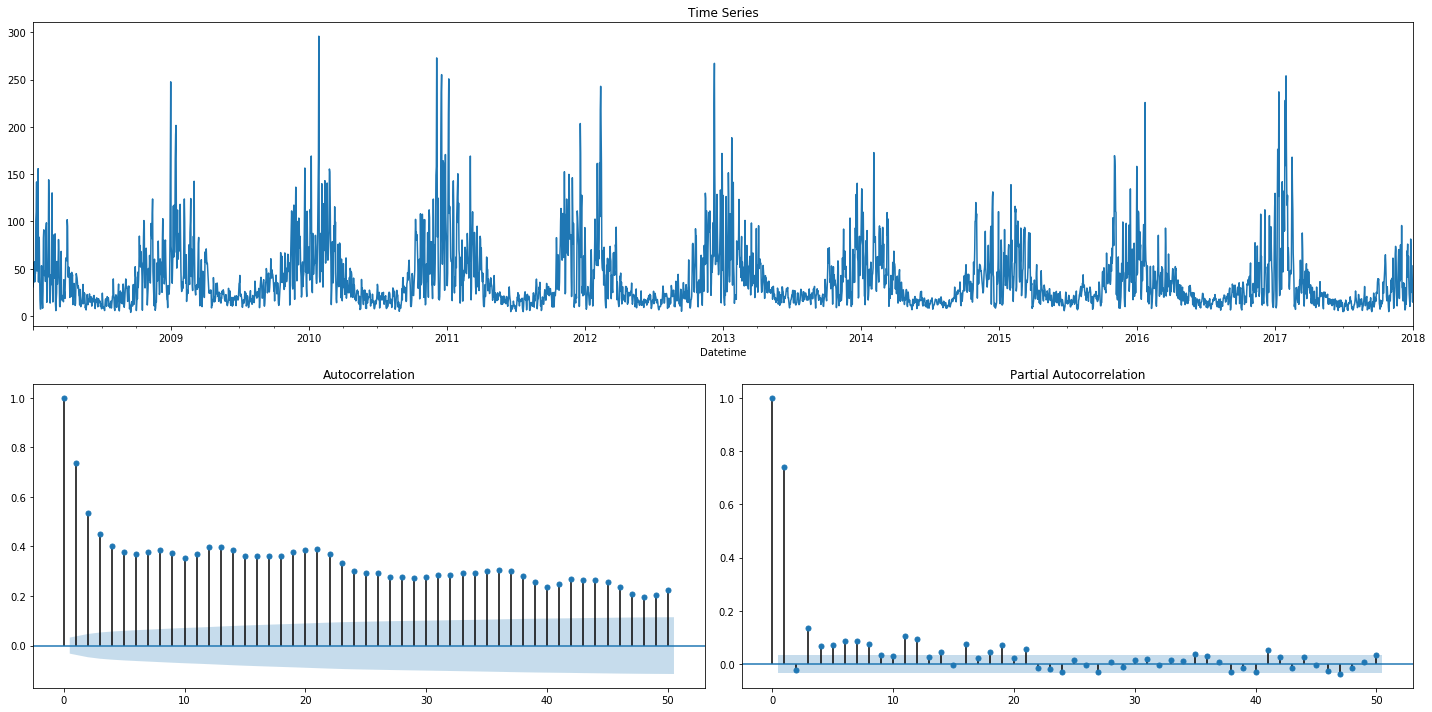

In [20]:
plot_ts_corr(df_train['pm25'])

In [ ]:
%%time
# Find best parameters (grid-search)
best_results = get_best_arima_params_for_time_series(data=df_train, 
                                                     seasonal=False, 
                                                     max_param_range_p=0, 
                                                     max_param_range_d=0, 
                                                     max_param_range_q=5) # MA model

In [ ]:
SARIMAX(0, 0, 0) - AIC:42732.42857170857
SARIMAX(0, 0, 1) - AIC:39486.751268534026
SARIMAX(0, 0, 2) - AIC:38227.462732788605
SARIMAX(0, 0, 3) - AIC:37659.688050720295
SARIMAX(0, 0, 4) - AIC:37314.49415506735
SARIMAX(0, 0, 5) - AIC:37086.79928563797
Best model is ARIMA(0, 0, 5) with AIC of 37086.79928563797
CPU times: user 6.96 s, sys: 811 ms, total: 7.77 s
Wall time: 1.81 s

In [95]:
%%time
# Train the model -> find best parameters
#df_train.index = pd.DatetimeIndex(df_train.index).to_period('D')
p = 0 # (AR) 
d = 0 # differencing
q = 10 # (MA)
model = SARIMAX(endog=df_train['pm25'], order=(p, d, q))
model_fitted = model.fit()

df_train.index

CPU times: user 5.06 s, sys: 897 ms, total: 5.96 s
Wall time: 1.48 s


PeriodIndex(['2008-01-02', '2008-01-03', '2008-01-04', '2008-01-05',
             '2008-01-06', '2008-01-07', '2008-01-08', '2008-01-09',
             '2008-01-10', '2008-01-11',
             ...
             '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
             '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30',
             '2017-12-31', '2018-01-01'],
            dtype='period[D]', name='Datetime', length=3653, freq='D')

In [75]:
model_fitted

In [23]:
# Estimated parameters
print(model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   pm25   No. Observations:                 3653
Model:               SARIMAX(0, 0, 5)   Log Likelihood              -16940.192
Date:                Tue, 09 Jun 2020   AIC                          33892.384
Time:                        21:10:24   BIC                          33929.604
Sample:                    01-02-2008   HQIC                         33905.639
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9441      0.009    108.407      0.000       0.927       0.961
ma.L2          0.7285      0.012     60.408      0.000       0.705       0.752
ma.L3          0.5963      0.012     48.111      0.0

In [24]:
# True parameters
print(f'The coefficients of the model are:\n {model_fitted.params}')

The coefficients of the model are:
 ma.L1       0.944070
ma.L2       0.728543
ma.L3       0.596271
ma.L4       0.435404
ma.L5       0.203968
sigma2    624.182183
dtype: float64


In [25]:
print(f'The residual errors during training of the model are:\n {model_fitted.resid}')

The residual errors during training of the model are:
 Datetime
2008-01-02    30.958333
2008-01-03    21.258348
2008-01-04     4.806204
2008-01-05    24.910633
2008-01-06   -10.435173
                ...    
2017-12-28   -16.069751
2017-12-29     4.699001
2017-12-30    19.078982
2017-12-31    -4.544337
2018-01-01    50.745771
Freq: D, Length: 3653, dtype: float64


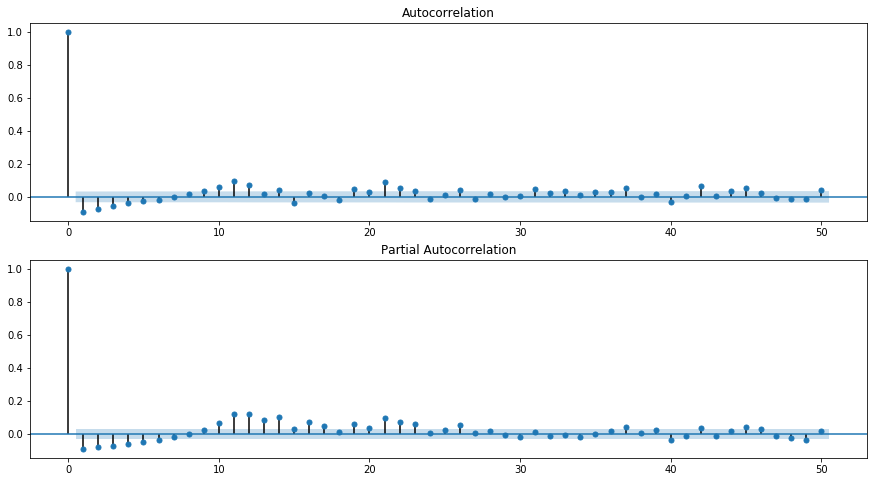

In [96]:
# Evaluate model quality
#model_fitted.plot_diagnostics(figsize=(18, 8))
#plt.show();
import statsmodels.api as sm
res = model_fitted.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [58]:
%%time
# Validate result on test
# Creates 365*24*24 models for hourly data, or 365*7 models for hourly data

fold_results = walk_forward_ts_model_validation2(data=df,
                                                 col_name='pm25',
                                                 p=p,
                                                 d=d,
                                                 q=q,
                                                 cut_off_offset=cut_off_offset,
                                                 n_pred_points=n_pred_points,
                                                 n_folds=-1,
                                                 period=period)
print(len(fold_results))
print(fold_results[0])

Started fold 004000/000365
365
             observed  predicted      error  abs_error
Datetime                                              
2018-01-02  67.991848  54.709948  13.281900  13.281900
2018-01-03  16.026950  43.506800  27.479850  27.479850
2018-01-04  14.590020  32.143511  17.553490  17.553490
2018-01-05  22.094854  21.183389   0.911465   0.911465
2018-01-06  62.504217  10.350621  52.153596  52.153596
2018-01-07  43.929804   0.000209  43.929595  43.929595
2018-01-08  22.088192   0.000101  22.088090  22.088090
CPU times: user 1h 47min 54s, sys: 12min 51s, total: 2h 45s
Wall time: 27min 19s


In [ ]:
%%time
# Train the model
model = AR(df_train)
model_fitted = model.fit()

In [ ]:
model_fitted

In [ ]:
print(f'The lag value chose is: {model_fitted.k_ar}')

In [ ]:
print(f'The coefficients of the model are:\n {model_fitted.params}')

In [ ]:
%%time
# Validate result on test
# Creates 365*60*24 models for hourly data, or 365*7 models for hourly data
fold_results = walk_forward_ts_model_validation_ma(data=df, 
                                         col_name='pm25', 
                                         model_params=model_fitted.params[:], 
                                         cut_off_offset=cut_off_offset, 
                                         n_pred_points=n_pred_points, 
                                         n_folds=-1)
print(len(fold_results))
print(fold_results[0])

### Serialize output data

In [97]:
from joblib import dump, load

timestamp = get_datetime_identifier("%Y-%m-%d_%H-%M-%S")

path = f'results/pm25_ts_{model_name}_results_d_{timestamp}.joblib'

dump(fold_results, path) 
fold_results = load(path)
print(len(fold_results))
print(fold_results[0])

365
             observed  predicted      error  abs_error
Datetime                                              
2018-01-02  67.991848  54.709948  13.281900  13.281900
2018-01-03  16.026950  43.506800  27.479850  27.479850
2018-01-04  14.590020  32.143511  17.553490  17.553490
2018-01-05  22.094854  21.183389   0.911465   0.911465
2018-01-06  62.504217  10.350621  52.153596  52.153596
2018-01-07  43.929804   0.000209  43.929595  43.929595
2018-01-08  22.088192   0.000101  22.088090  22.088090


### Calculate and visualize results

In [98]:
%%time
# Returns a list of mean folds RMSE for n_pred_points (starting at 1 point forecast)
res = get_mean_folds_rmse_for_n_prediction_points(fold_results=fold_results, n_pred_points=n_pred_points)
res

CPU times: user 2.31 s, sys: 6.45 ms, total: 2.32 s
Wall time: 2.32 s


[11.755884916201119,
 18.54064776536313,
 22.45893463687151,
 26.14217932960894,
 29.310016480446926,
 30.748041340782123,
 30.660515642458105]

In [99]:
print(res)

[11.755884916201119, 18.54064776536313, 22.45893463687151, 26.14217932960894, 29.310016480446926, 30.748041340782123, 30.660515642458105]


In [100]:
# Show forecasts for n-th point in the future
#show_n_points_of_forecasts = [1, 12, 24] # for hourly data
show_n_points_of_forecasts = [1, 3, 7] # for daily data

# Used to zoom the plots (date ranges shown in the plots)
# for hourly data
#start_end_dates = [('2018-01-01', '2019-01-01'), ('2018-02-01', '2018-03-01'), ('2018-06-01', '2019-07-01')]
# for daily data
start_end_dates = [('2018-01-01', '2019-01-01'), ('2018-02-01', '2018-04-01'), ('2018-06-01', '2019-08-01')]

# Type of plot
# 0 -> plot_observed_vs_predicted
# 1 -> plot_observed_vs_predicted_with_error
plot_types = [0, 1, 1]

# File names for plots (format png will be used, do not add .png extension)
#base_file_path = f'images/pm25_obs_vs_pred_365_h_ts_{model_name}' # for hourly data
base_file_path = f'images/pm25_obs_vs_pred_365_d_ts_{model_name}' # for daily data

In [102]:
visualize_results(show_n_points_of_forecasts=show_n_points_of_forecasts,
                   start_end_dates=start_end_dates,
                   plot_types=plot_types,
                   base_file_path=base_file_path,
                   fold_results=fold_results, 
                   n_pred_points=n_pred_points, 
                   cut_off_offset=cut_off_offset, 
                   model_name=model_name)

TypeError: Axis must have `freq` set to convert to Periods

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x129681b00> (for post_execute):


ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units